# Plug and Play ADMM with pretrained denoiser

In [79]:
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from skimage.transform import iradon

import scipy as sp
import pylab
import h5py

import torch
import torchvision
import torchvision.transforms as transforms
import time

## Data loading:

Projection matrix $A$:

In [2]:
import scipy.io
mat = scipy.io.loadmat('projection_matrices/thinL64_90')
A = mat['H'].todense()

In [3]:
A.shape

(8100, 4096)

Importing brain dataset:

In [4]:
import h5py

In [5]:
brains = []
for i in range(1, 767):
    with  h5py.File('brains-master/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [(brain - np.min(brain)) / (np.max(brain) - np.min(brain))]

brains = np.array(brains)
print(brains.shape)

(766, 64, 64)


Computing projections of each 2D image:

In [6]:
projections = []
for i in range(brains.shape[0]):
    p = np.matmul(A, brains[i].flatten())
    p = p.reshape((90,90))
    projections += [p]
    
projections = np.array(projections)
print(projections.shape)

(766, 90, 90)


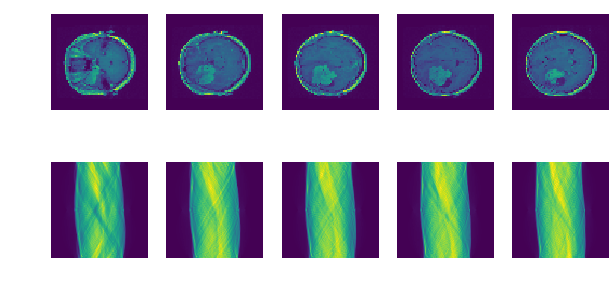

In [7]:
fig=plt.figure(figsize=(10, 5))

for i in range(5):
    idx = np.random.randint(766)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(brains[i])
    plt.axis('off')
    fig.add_subplot(2, 5, i+6)
    plt.imshow(projections[i])
    plt.axis('off')

Add noise to sinogram acquisition:

(-0.5, 63.5, 63.5, -0.5)

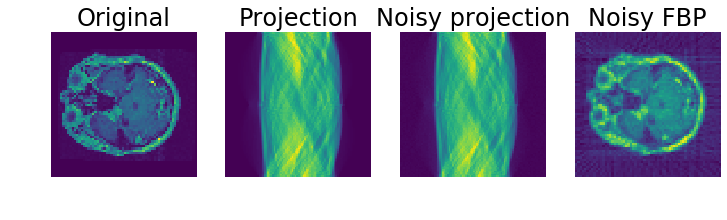

In [8]:
brain_sample = brains[5]
proj = np.matmul(A, brain_sample.flatten())
noises = np.random.uniform(5e-2, 1e-1, size=proj.shape)
proj_noisy = proj + np.random.normal(np.zeros(proj.shape), noises)
rec_fbp = np.rot90(iradon(proj_noisy.reshape(90, 90).T, output_size=64, circle=False))

fig=plt.figure(figsize=(12, 5))

fig.add_subplot(1, 4, 1)
plt.imshow(brain_sample)
plt.title("Original")
plt.axis('off')

fig.add_subplot(1, 4, 2)
plt.imshow(proj.reshape(90, 90))
plt.title("Projection")
plt.axis('off')

fig.add_subplot(1, 4, 3)
plt.imshow(proj_noisy.reshape(90, 90))
plt.title("Noisy projection")
plt.axis('off')

fig.add_subplot(1, 4, 4)
plt.imshow(rec_fbp)
plt.title("Noisy FBP")
plt.axis('off')

## Denoiser 

Here we use a pretrained denoiser. We can first observe the performance of this denoiser on some examples:

In [9]:
import os
os.chdir('denoiser')

import torch
from models import DnCNN

net = DnCNN(channels=1, num_of_layers=5)
net.load_state_dict(torch.load('logs/net.pth'))

Define image transformations (noise happens on the sinogram domain):

In [11]:
def noisy_fbp(x, A, noise_min=1e-2, noise_max=1e-1):
    # Gray scale
    x = x.convert('LA')
    # Projection
    p = np.matmul(A, np.array(x)[:,:,0].flatten())
    # Add noise
    noises = np.random.uniform(noise_min, noise_max, size=proj.shape)
    p = p + np.random.normal(np.zeros(proj.shape), noises)
    return np.rot90(iradon(p.reshape(90, 90).T, output_size=64, circle=False)).copy()

transform_train = transforms.Compose([
            transforms.CenterCrop(64),
            transforms.Lambda(lambda x: noisy_fbp(x, A)),
            transforms.ToTensor(),])

Load STL10 dataset (training dataset) and observe some denoisings:

In [12]:
from datasets import STL10

data = STL10('./STL10/', split='train', transform=transform_train, download=True)
loader_train = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True, num_workers=2)

Files already downloaded and verified


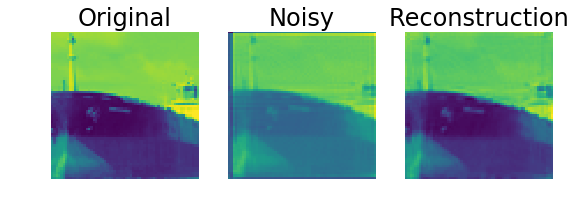

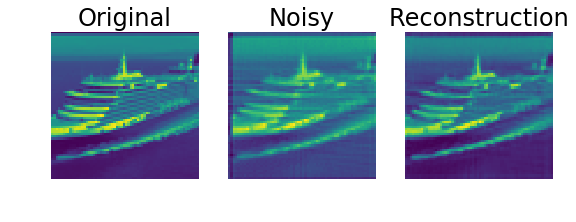

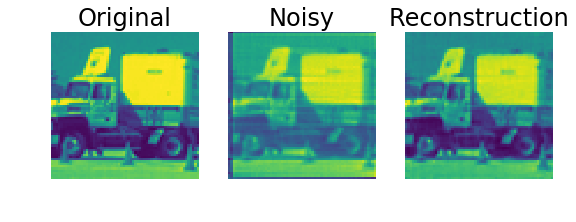

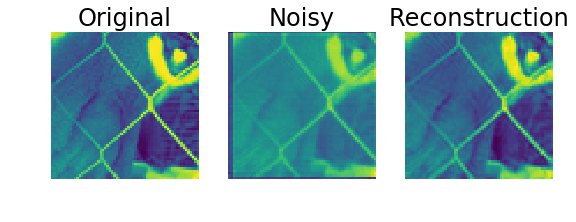

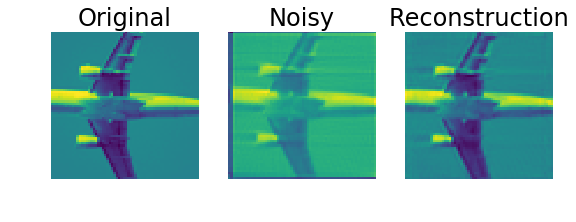

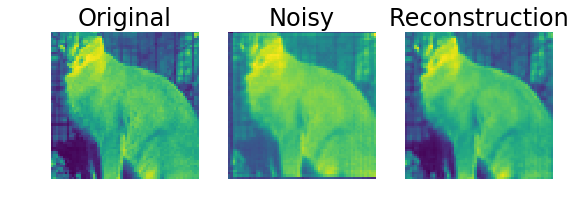

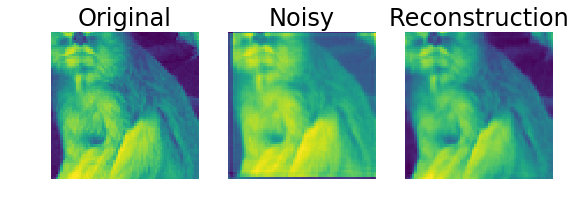

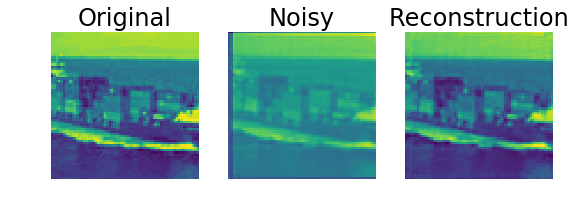

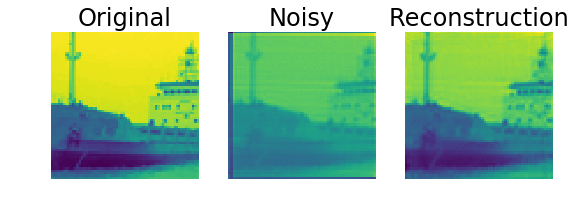

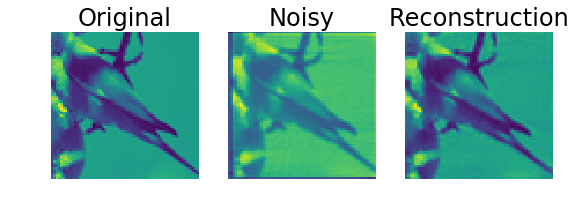

In [13]:
i = 0

for batch_idx, (image, image_noisy) in enumerate(loader_train):
    i += 1
    
    out_batch = net(image_noisy.float())
    
    for j in range(image.size()[0]):
        
        image_sample = image[j].numpy()
        image_noisy_sample = image_noisy[j].numpy()
        out_sample = out_batch[j].detach().numpy()
        
        fig=plt.figure(figsize=(9, 5))

        fig.add_subplot(1, 3, 1)
        plt.imshow(image_sample[0, :, :])
        plt.title("Original")
        plt.axis('off')

        fig.add_subplot(1, 3, 2)
        plt.imshow(image_noisy_sample[0, :, :])
        plt.title("Noisy")
        plt.axis('off')

        fig.add_subplot(1, 3, 3)
        plt.imshow(out_sample[0, :, :])
        plt.title("Reconstruction")
        plt.axis('off')
    
    if i>0:
        break

Use denoiser on brain images:

In [14]:
def denoising_image(image, net):
    input_ = np.expand_dims(np.expand_dims(image, 0), 0)
    input_ = torch.from_numpy(input_.copy())
    return net(input_.float()).detach().numpy()[0,0,:,:]

(-0.5, 63.5, 63.5, -0.5)

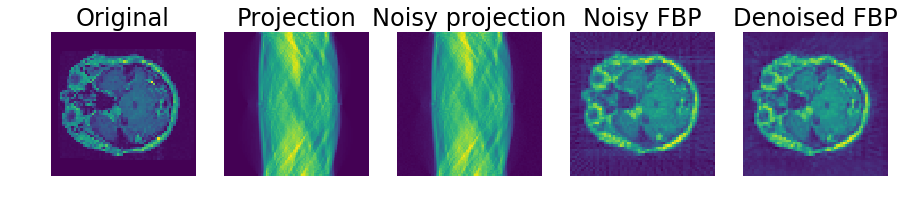

In [15]:
brain_sample = brains[5]
# Rescale brain 
brain_sample = (brain_sample - np.min(brain_sample)) / (np.max(brain_sample) - np.min(brain_sample))
proj = np.matmul(A, brain_sample.flatten())
noises = np.random.uniform(5e-2, 1e-1, size=proj.shape)
proj_noisy = proj + np.random.normal(np.zeros(proj.shape), noises)
rec_fbp = np.rot90(iradon(proj_noisy.reshape(90, 90).T, output_size=64, circle=False))

fig=plt.figure(figsize=(15, 5))

fig.add_subplot(1, 5, 1)
plt.imshow(brain_sample)
plt.title("Original")
plt.axis('off')

fig.add_subplot(1, 5, 2)
plt.imshow(proj.reshape(90, 90))
plt.title("Projection")
plt.axis('off')

fig.add_subplot(1, 5, 3)
plt.imshow(proj_noisy.reshape(90, 90))
plt.title("Noisy projection")
plt.axis('off')

fig.add_subplot(1, 5, 4)
plt.imshow(rec_fbp)
plt.title("Noisy FBP")
plt.axis('off')


fig.add_subplot(1, 5, 5)
plt.imshow(denoising_image(rec_fbp, net))
plt.title("Denoised FBP")
plt.axis('off')

## ADMM with pretrained denoiser:

In [158]:
from optimizers import PlugAndPlayADMM

Problem definition:

In [152]:
brain_sample = brains[5].flatten()

proj = np.squeeze(np.array(np.matmul(A, brain_sample.flatten())))
noises = np.random.uniform(5e-2, 9e-1, size=proj.shape)
proj = proj + np.random.normal(np.zeros(proj.shape), noises)

x0 = np.zeros(brain_sample.shape[0])
rho = 1.

Definition of optimizer and resolution:

In [153]:
ADMM_optimizer = PlugAndPlayADMM(x0, A, rho, proj, net, save_f=True)

In [154]:
tol = 1e-2
max_iter = 20

x_pap_admm = ADMM_optimizer.solve(x0, tol, max_iter)

Duration : 0.5575733184814453


Fitness to data measure along iterations:

Text(0, 0.5, 'Fitness to data')

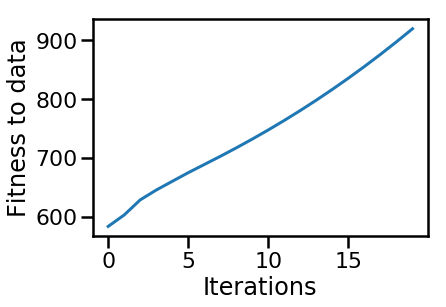

In [155]:
plt.plot([i for i in range(len(ADMM_optimizer.list_f))], ADMM_optimizer.list_f)
plt.xlabel('Iterations')
plt.ylabel('Fitness to data')

Data fitness "deteriorates" along iterations: ADMM starts from the "minimal norm solution" and progressively adds prior (here denoising) along iterations.

(-0.5, 63.5, 63.5, -0.5)

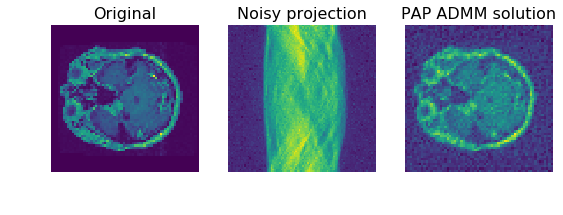

In [156]:
fig=plt.figure(figsize=(9, 5))

fig.add_subplot(1, 3, 1)
plt.imshow(brain_sample.reshape(64, 64))
plt.title("Original", fontsize=16)
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(proj.reshape(90, 90))
plt.title("Noisy projection", fontsize=16)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(x_pap_admm.reshape(64, 64))
plt.title("PAP ADMM solution", fontsize=16)
plt.axis('off')

Comparison to minimal norm solution:

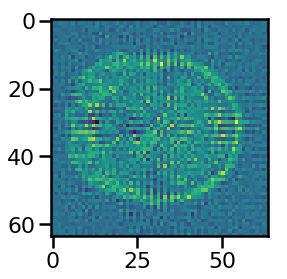

In [157]:
pseudo_inv = np.linalg.inv( (A.T).dot(A) )
At_proj = np.squeeze(np.array( (A.T).dot(proj) ))
z = pseudo_inv.dot(At_proj)

plt.imshow(z.reshape(64, 64))